In [ ]:
import numpy as np
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU, ReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input, Embedding, Concatenate, BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets.cifar10 import load_data

The below code is adapted from https://github.com/gheisenberg/AML.

In [2]:
def define_discriminator(in_shape=(32,32,3)):
    model = Sequential(name="discriminator")

    # Inputs an image
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape)) #16x16x128
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) #8x8x128
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten()) #shape of 8192
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid')) #shape of 1

    # outputs a probability that the image is real (1) or artificial (0)
    # Compile model since it is going to be trained directly and choose the optimizer
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

test_discriminator = define_discriminator()
print(test_discriminator.summary())

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1)               

2023-11-18 05:48:06.408725: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-18 05:48:06.441660: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-18 05:48:06.441781: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
def define_larger_discriminator(in_shape=(32,32,3)):
    model = Sequential(name="large_discriminator")
    # normal
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

test_discriminator = define_larger_discriminator()
print(test_discriminator.summary())

Model: "large_discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 256) 

#### Define the standalone generator model
Given the latent vector input, the Generator produces an image.(here: 32x32)
The latent_dim, for example, can be 100, 1D array of size 100. 

Only Dense and conv2dlayers are being used. But the network can be more complicated based on the problem you are trying to solve. For example, you can use VGG as the basis for a super resolution GAN. 

In [5]:
#latent_dim is the dimension of the latent vector (e.g., 100 - see below)
def define_generator(latent_dim):    
    
    model = Sequential(name="generator")

    # Reshape the input latent vector into an 8x8 image as a starting point. 
    # Hence n_nodes for the Dense layer are e.g. 128x8x8, so when reshaping the output 
    # it would be 8x8x128 and that can be slowly upscaled to a 32x32 image as the output.
    n_nodes = 128 * 8 * 8  #8192 nodes
    model.add(Dense(n_nodes, input_dim=latent_dim)) #Dense layer so we can work with a 1D latent vector
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8, 8, 128)))  #8x8x128 data set from the latent vector. 
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #16x16x128
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #32x32x128
    model.add(LeakyReLU(alpha=0.2))
    # generate
    model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) #32x32x3
    return model  # the generator model not compiled as it is not directly trained as the discriminator.
                  # the generator is being trained via a GAN combined model (see below)

test_generator = define_generator(latent_dim=100)
print(test_generator.summary())

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8192)              827392    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       262272    
 anspose)                                                        
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 128)       262272    
 Transpose)                                              

In [6]:
def define_larger_generator(latent_dim):
    model = Sequential(name="norm_generator")
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model

test_generator = define_larger_generator(latent_dim=100)
print(test_generator.summary())

Model: "norm_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 4096)              0         
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 8, 8, 128)         524416    
 Transpose)                                                      
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 16, 16, 128)       262272    
 Transpose)                                         

In [8]:
def define_gan(generator, discriminator):
    # The discriminator is trained separately (see above). Hence, set it to not trainable.
    discriminator.trainable = False  
    
    # Now, connect the generator and the discriminator
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    
    # Compile the combined model and Choose an optimizer
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    
    return model

In [12]:
# Load the cifar images and build a training data set
def load_real_samples():
    (trainX, _), (_, _) = load_data()
    # convert to float and scale.
    X = trainX.astype('float32')
    # the generator uses tanh as activation function right at the very end, before the output (see above), 
    # so we need to rescale from [0,255] to [-1,1]
    # original images to -1 to 1 to match the output of generator.
    X = (X - 127.5) / 127.5  
    
    return X

In [13]:
# Pick a batch of random real samples to train the GAN
# In fact, train the GAN on a half batch of real images and another half batch of fake images. 
# For each real image assign the label=1 and for fake assign the label=0. 
def generate_real_samples(dataset, n_samples):
    # choose random images
    ix = randint(0, dataset.shape[0], n_samples)
    # select the random images and assign it to X
    x = dataset[ix]
    # generate class labels and assign to y
    y = ones((n_samples, 1)) # label=1 indicates that the image is a real one
    return x, y

In [14]:
# Generate n_samples number of latent vectors as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples) # randn samples from the standard normal distribution - our latent space
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [15]:
# Use the generator to generate n fake examples, with class labels
# Supply the generator, latent_dim and number of samples as input.
# Use the above latent point generator to generate latent points. 
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict using generator to generate fake samples. 
    x = generator.predict(x_input, verbose=0)
    # Class labels will be 0 as these samples are fake. 
    y = zeros((n_samples, 1))  # label=0 indicates that the image is a fake one # the 1 refers to the shape size, this produces all 0s
    return x, y

In [16]:
def train(g_model, d_model, gan_model, filename, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)  #the discriminator model is updated for a half batch of real samples 
                            #and a half batch of fake samples, combined making a single batch. 
    # manually enumerate epochs and bacthes. 
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
                
            # Train the discriminator on real and fake images, separately (half batch each)
            #Research showed that separate training is more effective. 
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            ##train_on_batch allows you to update weights based on a collection 
            #of samples you provide
            #Let us just capture loss and ignore accuracy value (2nd output below)
            d_loss_real, _ = d_model.train_on_batch(X_real, y_real) 
            
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)
            
            #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #Average loss if you want to report single..
            
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
             
            # The generator wants the discriminator to label the generated samples as valid ones.
            # This is where the generator is trying to trick discriminator into believing that 
            # the generated image is true (hence value of 1 for y)
            y_gan = ones((n_batch, 1))

            # The generator is part of the combined model where it got directly linked with the discriminator
            # Train the generator with latent_dim as x and 1 as y. 
            # Again, 1 as the output as it is adversarial and if the generator did a great
            # job of fooling the discriminator, then the output would be 1 (true).
            # Update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
            # Print losses on this batch
            #print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
            #     (i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
        print('Epoch>%d, discrim_real_loss=%.3f, discrim_fake_loss=%.3f gen_loss=%.3f' % (i+1, d_loss_real, d_loss_fake, g_loss))
    # save the generator model
    g_model.save(filename)

In [10]:
def show_plot(examples, n):
    fig, axes = plt.subplots(nrows=n, ncols=n, figsize=(10, 10))
    k=0
    for i in range(n):
        for j in range(n):
            axes[i, j].imshow(examples[k, :, :, :])
            axes[i, j].axis("off")
            k+=1
    plt.show()

Some of the below code has been adapted from https://machinelearningmastery.com/ and improvement tips specifically from https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/

The tips to improve quality that have already been included in the code include:
* Using strided convolutions instead of pooling layers
* Using leaky ReLU and Tanh, with inputs in range [-1, 1]
* Use Adam optimisation
* Use mini batches contacting all real and all fake images when training the discriminator
  
The main changes to improve quality that I have therefore tested are:
* Training with more epochs
* Training with a larger latent dimension
* Training with a larger generator/discriminator architecture
* Training a conditional GAN (e.g. including labels)

## Training with 50 epochs:

In [ ]:
latent_dim = 100
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)
dataset = load_real_samples()
n_epochs = 50
model_filename = "models/cifar_generator." + str(n_epochs) + "_epochs_" + str(latent_dim) + "_latent_dims.model"
train(generator, discriminator, gan_model, model_filename, dataset, latent_dim, n_epochs)

1/1 [==============================] - 0s 34ms/step


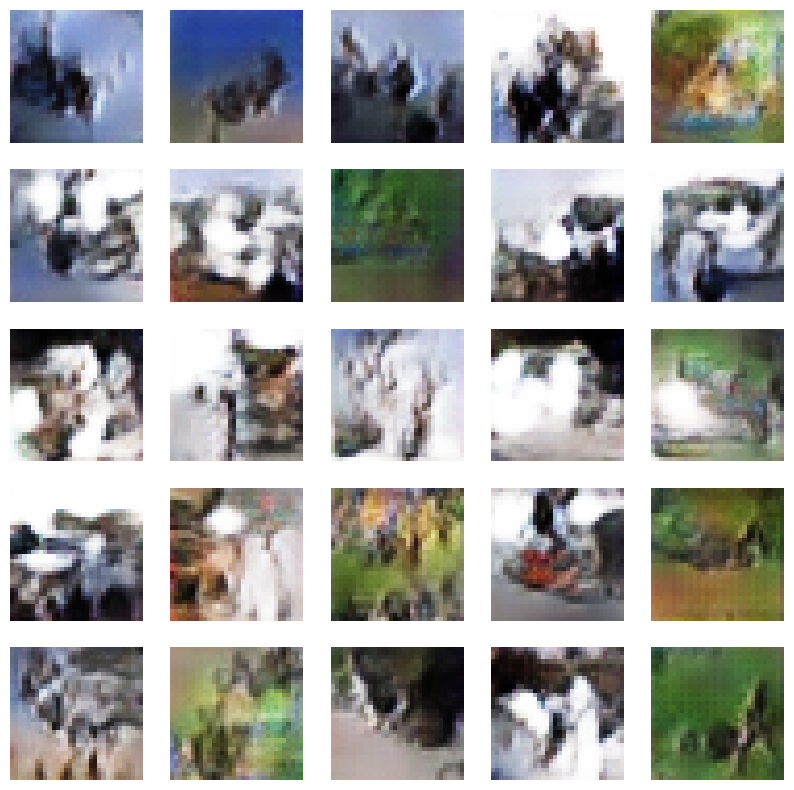

In [18]:
model = load_model("models/cifar_generator.50_epochs_100_latent_dims.model")
latent_points = generate_latent_points(100, 25)
X = model.predict(latent_points)
X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)
show_plot(X, 5)

## Training with 100 epochs:

In [18]:
latent_dim = 100
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)
dataset = load_real_samples()
n_epochs = 100
model_filename = "models/cifar_generator." + str(n_epochs) + "_epochs_" + str(latent_dim) + "_latent_dims.model"
train(generator, discriminator, gan_model, model_filename, dataset, latent_dim, n_epochs)

2023-11-17 09:41:27.574500: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-17 09:41:28.195569: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9648e058a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-17 09:41:28.195583: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2023-11-17 09:41:28.197619: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-17 09:41:28.243868: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch>1, discrim_real_loss=0.488, discrim_fake_loss=0.698 gen_loss=0.803
Epoch>2, discrim_real_loss=0.702, discrim_fake_loss=0.669 gen_loss=0.753
Epoch>3, discrim_real_loss=0.671, discrim_fake_loss=0.746 gen_loss=0.703
Epoch>4, discrim_real_loss=0.658, discrim_fake_loss=0.578 gen_loss=0.951
Epoch>5, discrim_real_loss=0.730, discrim_fake_loss=0.633 gen_loss=0.789
Epoch>6, discrim_real_loss=0.716, discrim_fake_loss=0.648 gen_loss=0.808
Epoch>7, discrim_real_loss=0.670, discrim_fake_loss=0.708 gen_loss=0.703
Epoch>8, discrim_real_loss=0.776, discrim_fake_loss=0.556 gen_loss=0.952
Epoch>9, discrim_real_loss=0.661, discrim_fake_loss=0.666 gen_loss=0.860
Epoch>10, discrim_real_loss=0.769, discrim_fake_loss=0.586 gen_loss=0.890
Epoch>11, discrim_real_loss=0.722, discrim_fake_loss=0.697 gen_loss=0.739
Epoch>12, discrim_real_loss=0.675, discrim_fake_loss=0.604 gen_loss=0.847
Epoch>13, discrim_real_loss=0.683, discrim_fake_loss=0.698 gen_loss=0.749
Epoch>14, discrim_real_loss=0.697, discrim_fake

INFO:tensorflow:Assets written to: cifar_generator.100_epochs_100_latent_dims.model/assets


1/1 [==============================] - 0s 140ms/step


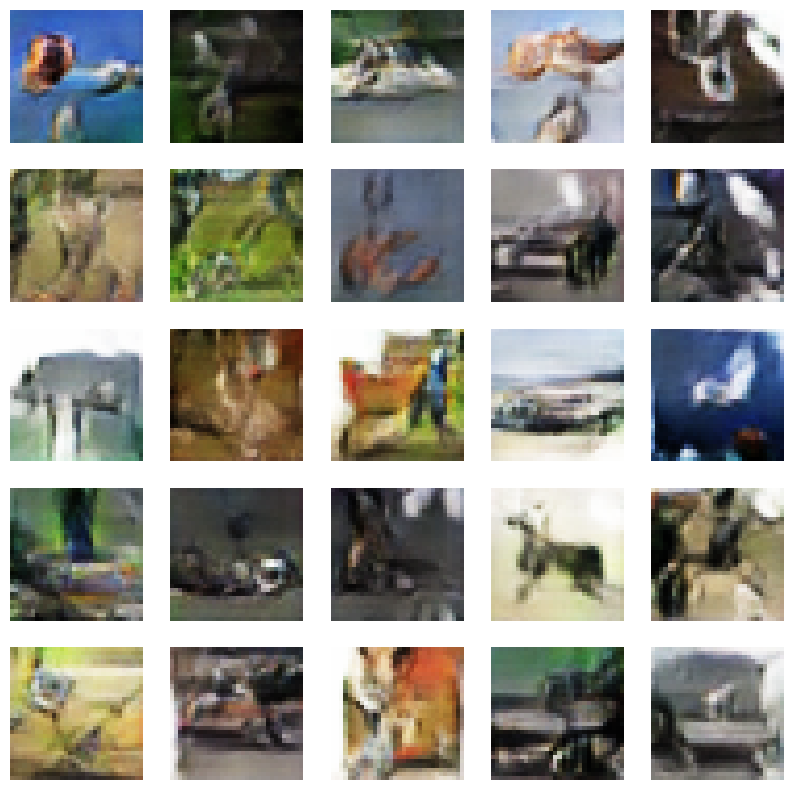

In [19]:
model = load_model("models/cifar_generator.100_epochs_100_latent_dims.model")
latent_points = generate_latent_points(100, 25)
X = model.predict(latent_points)
X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)
show_plot(X, 5)

## Training with 200 epochs:

In [ ]:
latent_dim = 100
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)
dataset = load_real_samples()
n_epochs = 200
model_filename = "models/cifar_generator." + str(n_epochs) + "_epochs_" + str(latent_dim) + "_latent_dims.model"
train(generator, discriminator, gan_model, model_filename, dataset, latent_dim, n_epochs)

1/1 [==============================] - 0s 34ms/step


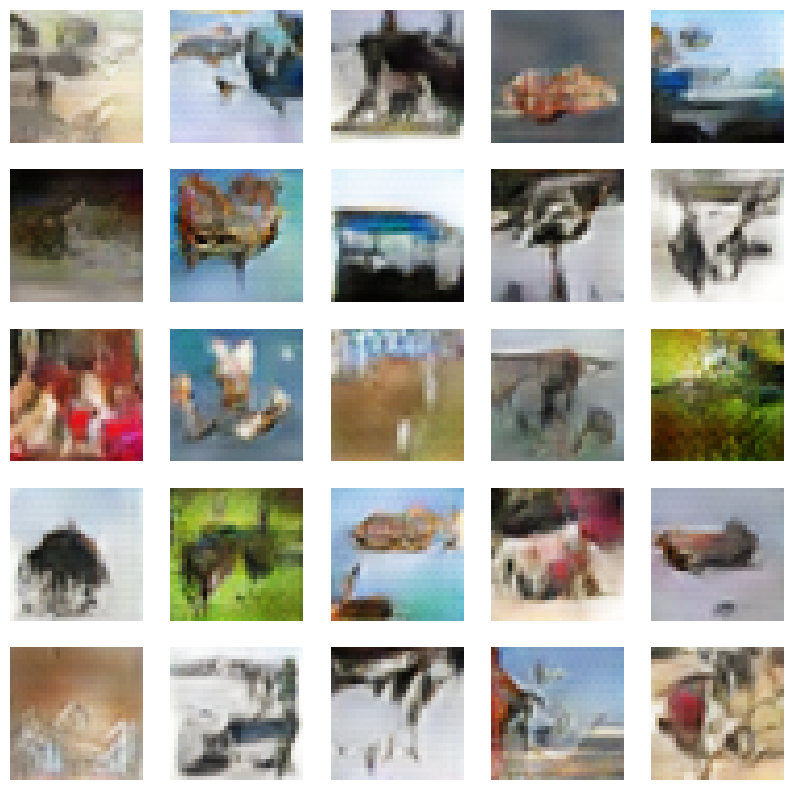

In [22]:
model = load_model("models/cifar_generator.200_epochs_100_latent_dims.model")
latent_points = generate_latent_points(100, 25)
X = model.predict(latent_points)
X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)
show_plot(X, 5)

**Conclusion**: the results certainly improve when increasing the number of epochs, especially from 50 to 100 epochs. However, the difference between 100 and 200 epochs is not extremely large, and as it takes literally double the amount of time to train 200 epochs, for the next experiments, I will use 100 epochs instead.

## Training with a latent space of 200 and 100 epochs:

In [24]:
latent_dim = 200
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)
dataset = load_real_samples()
n_epochs = 100
model_filename = "models/cifar_generator." + str(n_epochs) + "_epochs_" + str(latent_dim) + "_latent_dims.model"
train(generator, discriminator, gan_model, model_filename, dataset, latent_dim, n_epochs)

Epoch>1, discrim_real_loss=0.707, discrim_fake_loss=0.183 gen_loss=2.440
Epoch>2, discrim_real_loss=0.344, discrim_fake_loss=1.131 gen_loss=0.708
Epoch>3, discrim_real_loss=0.408, discrim_fake_loss=0.307 gen_loss=1.850
Epoch>4, discrim_real_loss=0.627, discrim_fake_loss=0.617 gen_loss=1.339
Epoch>5, discrim_real_loss=0.847, discrim_fake_loss=0.317 gen_loss=1.954
Epoch>6, discrim_real_loss=0.731, discrim_fake_loss=0.723 gen_loss=0.761
Epoch>7, discrim_real_loss=0.786, discrim_fake_loss=0.619 gen_loss=0.844
Epoch>8, discrim_real_loss=0.567, discrim_fake_loss=0.765 gen_loss=0.682
Epoch>9, discrim_real_loss=0.787, discrim_fake_loss=0.754 gen_loss=0.923
Epoch>10, discrim_real_loss=0.619, discrim_fake_loss=0.773 gen_loss=0.764
Epoch>11, discrim_real_loss=0.550, discrim_fake_loss=0.737 gen_loss=0.774
Epoch>12, discrim_real_loss=0.914, discrim_fake_loss=0.384 gen_loss=2.176
Epoch>13, discrim_real_loss=0.589, discrim_fake_loss=0.586 gen_loss=1.008
Epoch>14, discrim_real_loss=0.577, discrim_fake

INFO:tensorflow:Assets written to: cifar_generator.100_epochs_200_latent_dims.model/assets


1/1 [==============================] - 0s 35ms/step


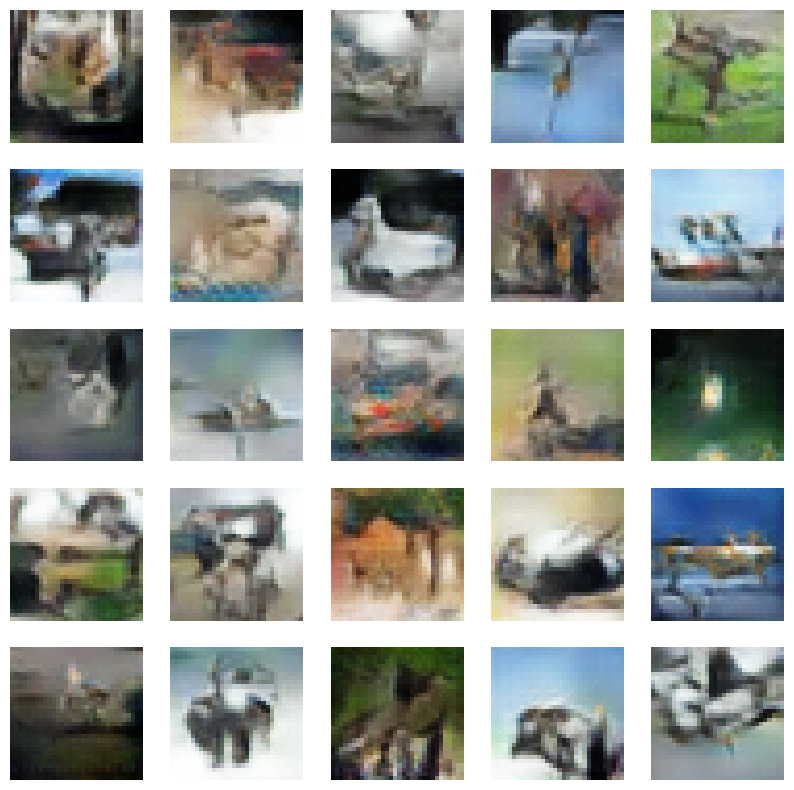

In [30]:
model = load_model("models/cifar_generator.100_epochs_200_latent_dims.model")
latent_points = generate_latent_points(200, 25)
X = model.predict(latent_points)
X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)
show_plot(X, 5)

**Conclusion**: **Using a latent space of 200 over 100 epochs isn't a huge improvement on using a latent space of 100 over 100 epochs.** A latent vector of 100 elements thus seems to be sufficient for the generator to be able to create a complex enough function within the NN, that it can generate reasonable looking artifical images. I therefore again stick to a latent dimension of 100, for efficiency reasons.

## Training with a larger generator and discriminator architecture

In [19]:
latent_dim = 100
discriminator = define_larger_discriminator()
generator = define_larger_generator(latent_dim)
gan_model = define_gan(generator, discriminator)
dataset = load_real_samples()
n_epochs = 100
model_filename = "models/cifar_larger_generator." + str(n_epochs) + "_epochs_" + str(latent_dim) + "_latent_dims.model"
train(generator, discriminator, gan_model, model_filename, dataset, latent_dim, n_epochs)

2023-11-17 08:56:58.331770: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-17 08:56:59.429787: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1cfd67fa70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-17 08:56:59.429803: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2023-11-17 08:56:59.435177: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-17 08:56:59.494055: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch>1, discrim_real_loss=0.404, discrim_fake_loss=0.237 gen_loss=2.278
Epoch>2, discrim_real_loss=0.783, discrim_fake_loss=0.546 gen_loss=1.291
Epoch>3, discrim_real_loss=0.537, discrim_fake_loss=0.470 gen_loss=1.322
Epoch>4, discrim_real_loss=0.442, discrim_fake_loss=0.567 gen_loss=1.311
Epoch>5, discrim_real_loss=0.516, discrim_fake_loss=0.373 gen_loss=1.650
Epoch>6, discrim_real_loss=0.576, discrim_fake_loss=0.516 gen_loss=1.363
Epoch>7, discrim_real_loss=0.549, discrim_fake_loss=0.558 gen_loss=1.245
Epoch>8, discrim_real_loss=0.625, discrim_fake_loss=0.506 gen_loss=1.291
Epoch>9, discrim_real_loss=0.519, discrim_fake_loss=0.571 gen_loss=1.156
Epoch>10, discrim_real_loss=0.630, discrim_fake_loss=0.616 gen_loss=1.091
Epoch>11, discrim_real_loss=0.709, discrim_fake_loss=0.575 gen_loss=0.891
Epoch>12, discrim_real_loss=0.716, discrim_fake_loss=0.559 gen_loss=0.903
Epoch>13, discrim_real_loss=0.675, discrim_fake_loss=0.599 gen_loss=0.903
Epoch>14, discrim_real_loss=0.598, discrim_fake

INFO:tensorflow:Assets written to: cifar_larger_generator.100_epochs_100_latent_dims.model/assets


1/1 [==============================] - 0s 40ms/step


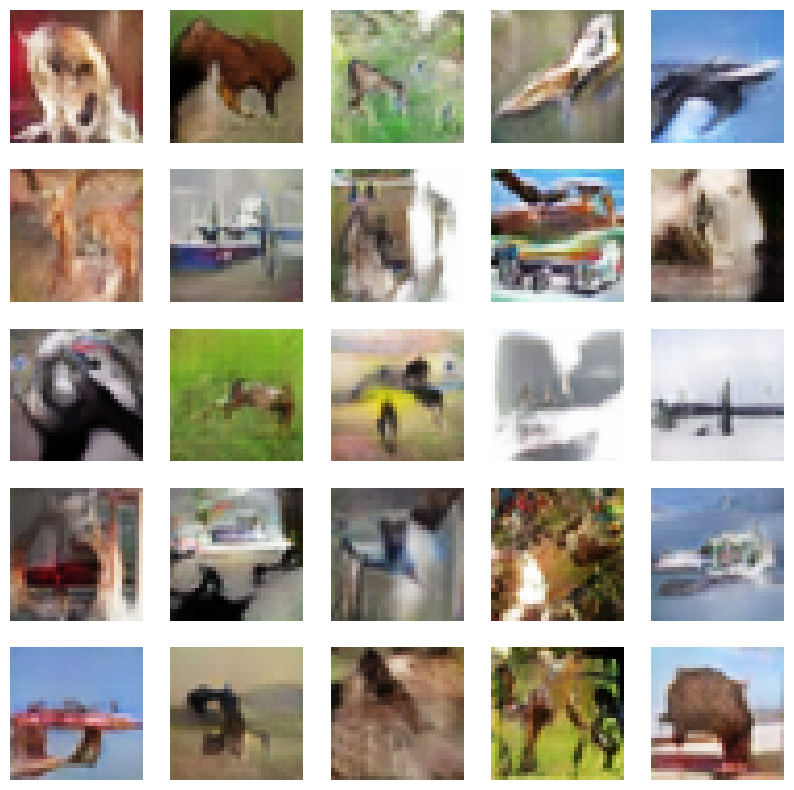

In [24]:
model = load_model("models/cifar_larger_generator.100_epochs_100_latent_dims.model")
latent_points = generate_latent_points(100, 25)
X = model.predict(latent_points)
X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)
show_plot(X, 5)

**Conclusion**: **Using a slightly larger architecture (more parameters) improves the generated artifical images** in the sense that they are comprised of more clearer, well-defined shapes, rather than very blurry, fuzzy images, as in the previous model.

## Training a conditional GAN

In [2]:
def conditional_discriminator(in_shape=(32,32,3), n_classes=10):
     
     in_label = Input(shape=(1,)) # This is the condition - the class label
     li = Embedding(n_classes, 50)(in_label) # Creating an embedding for the class label
     # "each of the 10 classes will map to a different 50-element vector representation 
     # that will be learned by the discriminator model."
     li = Dense(in_shape[0] * in_shape[1])(li) # scale up the vector to the image dimensions
     li = Reshape((in_shape[0], in_shape[1], 1))(li)  # reshape so it can be added as a channel
    
     in_image = Input(shape=in_shape) # the input image, either real or created by the generator
     merge = Concatenate()([in_image, li]) # concat embedded class label as a channel to the image
    
     fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
     fe = LeakyReLU(alpha=0.2)(fe)
     fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
     fe = LeakyReLU(alpha=0.2)(fe)
     fe = Flatten()(fe)
     fe = Dropout(0.4)(fe)
     out_layer = Dense(1, activation='sigmoid')(fe)

     model = Model([in_image, in_label], out_layer)

     opt = Adam(learning_rate=0.0002, beta_1=0.5)
     model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
     return model

In [3]:
def conditional_larger_discriminator(in_shape=(32,32,3), n_classes=10):
     
     in_label = Input(shape=(1,)) # This is the condition - the class label
     li = Embedding(n_classes, 50)(in_label) # Creating an embedding for the class label
     # "each of the 10 classes will map to a different 50-element vector representation 
     # that will be learned by the discriminator model."
     li = Dense(in_shape[0] * in_shape[1])(li) # scale up the vector to the image dimensions
     li = Reshape((in_shape[0], in_shape[1], 1))(li)  # reshape so it can be added as a channel
    
     in_image = Input(shape=in_shape) # the input image, either real or created by the generator
     merge = Concatenate()([in_image, li]) # concat embedded class label as a channel to the image
    
     fe = Conv2D(64, (3,3), strides=(2,2), padding='same')(merge)
     fe = LeakyReLU(alpha=0.2)(fe)
     fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
     fe = LeakyReLU(alpha=0.2)(fe)
     fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
     fe = LeakyReLU(alpha=0.2)(fe)
     fe = Conv2D(256, (3,3), strides=(2,2), padding='same')(fe)
     fe = LeakyReLU(alpha=0.2)(fe)
     fe = Flatten()(fe)
     fe = Dropout(0.4)(fe)
     out_layer = Dense(1, activation='sigmoid')(fe)

     model = Model([in_image, in_label], out_layer)

     opt = Adam(learning_rate=0.0002, beta_1=0.5)
     model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
     return model

In [4]:
def conditional_generator(latent_dim, n_classes=10):
    in_label = Input(shape=(1,)) # This is the condition - the class label
    li = Embedding(n_classes, 50)(in_label) # Creating an embedding for the class label
    li = Dense(8 * 8)(li) # scale up the vector to the image dimensions
    li = Reshape((8, 8, 1))(li) # reshape so it can be added as a channel
    
    in_lat = Input(shape=(latent_dim,)) # this is the starting image sampled from 1d latent vector
    gen = Dense(128 * 8 * 8)(in_lat) # starting with an 8x8 image
    gen = ReLU()(gen)
    gen = Reshape((8, 8, 128))(gen) 
    
    merge = Concatenate()([gen, li]) # concat embedded class label as a channel to the image
    
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge) #16x16x128
    gen = ReLU()(gen)
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen) #32x32x128
    gen = ReLU()(gen)
    
    out_layer = Conv2D(3, (8,8), activation='tanh', padding='same')(gen) #32x32x128
    model = Model([in_lat, in_label], out_layer)
    
    return model

In [5]:
def conditional_larger_generator(latent_dim, n_classes=10):
    in_label = Input(shape=(1,)) # This is the condition - the class label
    li = Embedding(n_classes, 50)(in_label) # Creating an embedding for the class label
    li = Dense(4 * 4)(li) # scale up the vector to the image dimensions
    li = Reshape((4, 4, 1))(li) # reshape so it can be added as a channel
    
    in_lat = Input(shape=(latent_dim,)) # this is the starting image sampled from 1d latent vector
    gen = Dense(256 * 4 * 4)(in_lat) # starting with an 8x8 image
    gen = ReLU()(gen)
    gen = Reshape((4, 4, 256))(gen)
    
    merge = Concatenate()([gen, li]) # concat embedded class label as a channel to the image
    
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge) 
    gen = ReLU()(gen)
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = ReLU()(gen)
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = ReLU()(gen)    
    out_layer = Conv2D(3, (3,3), activation='tanh', padding='same')(gen) 
    model = Model([in_lat, in_label], out_layer)
    
    return model

In [6]:
def conditional_gan(g_model, d_model):
    d_model.trainable = False
    
    # when using the functional, not sequential mode, you need to define the inputs/outputs
    
    gen_noise, gen_label = g_model.input # define the inputs to the generator
    gen_output = g_model.output # define the generator outputs
    gan_output = d_model([gen_output, gen_label]) # discriminator takes gen output and label as input
    model = Model([gen_noise, gen_label], gan_output) 
    # whole model takes gen inputs as input, and discrim outputs as output
    
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [7]:
def load_real_conditional_samples():
    (trainX, trainy), (_, _) = load_data() # load both real images and their labels
    X = trainX.astype('float32')
    X = (X - 127.5) / 127.5
    return [X, trainy]

In [8]:
def generate_real_conditional_samples(dataset, n_samples):
    images, labels = dataset
    ix = randint(0, images.shape[0], n_samples)
    X, labels = images[ix], labels[ix]
    y = ones((n_samples, 1)) # label=1 for the discrim indicates that the image is a real one
    return [X, labels], y

In [9]:
def generate_conditional_latent_points(latent_dim, n_samples, n_classes=10):
    x_input = randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    # randomly generate some class labels to create artifical images of
    labels = randint(0, n_classes, n_samples) 
    return [z_input, labels]

In [10]:
def generate_conditional_fake_samples(generator, latent_dim, n_samples):
    z_input, labels_input = generate_conditional_latent_points(latent_dim, n_samples)
    images = generator.predict([z_input, labels_input], verbose=0) # create the artificial images
    y = zeros((n_samples, 1))
    return [images, labels_input], y # label=0 indicates that the image is a fake one

In [11]:
def show_cond_plot(examples, n):
    named_labels=["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
    fig, axes = plt.subplots(nrows=n, ncols=n, figsize=(10, 10))
    k=0
    for i in range(n):
        for j in range(n):
            axes[i, j].imshow(examples[k, :, :, :])
            axes[i, j].axis("off")
            k+=1
    for j in range(n):
        axes[0, j].set_title(named_labels[j])
    plt.show()

In [12]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, filename, n_batch=128):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)

    for i in range(n_epochs):
        for j in range(bat_per_epo):

            [X_real, labels_real], y_real = generate_real_conditional_samples(dataset, half_batch)
            # train discriminator on real
            d_loss_real, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            # train the discriminator on artificial
            [X_fake, labels], y_fake = generate_conditional_fake_samples(g_model, latent_dim, half_batch)
            d_loss_fake, _ = d_model.train_on_batch([X_fake, labels], y_fake)

            # sample from the latent space
            [z_input, labels_input] = generate_conditional_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            # train the generator 
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
        
        print('Epoch>%d, discrim_real_loss=%.3f, discrim_fake_loss=%.3f gen_loss=%.3f' % (i+1, d_loss_real, d_loss_fake, g_loss))
        #if i%50==0:
            #g_model.save(filename)    
    g_model.save(filename)

### Train the conditional model with 100 epochs:

In [50]:
latent_dim = 100
conditional_d_model = conditional_discriminator()
conditional_g_model = conditional_generator(latent_dim)
conditional_gan_model = conditional_gan(conditional_g_model, conditional_d_model)
conditional_dataset = load_real_conditional_samples()
n_epochs = 100
cond_filename = "models/cifar_cond_generator." + str(n_epochs) + "_epochs_" + str(latent_dim) + "_latent_dims.model"
train(conditional_g_model, conditional_d_model, conditional_gan_model, conditional_dataset, latent_dim, n_epochs, cond_filename)

Epoch>1, discrim_real_loss=0.780, discrim_fake_loss=0.645 gen_loss=0.967
Epoch>2, discrim_real_loss=0.746, discrim_fake_loss=0.657 gen_loss=0.847
Epoch>3, discrim_real_loss=0.667, discrim_fake_loss=0.626 gen_loss=0.924
Epoch>4, discrim_real_loss=0.606, discrim_fake_loss=0.623 gen_loss=0.865
Epoch>5, discrim_real_loss=0.613, discrim_fake_loss=0.689 gen_loss=0.767
Epoch>6, discrim_real_loss=0.658, discrim_fake_loss=0.643 gen_loss=0.830
Epoch>7, discrim_real_loss=0.690, discrim_fake_loss=0.673 gen_loss=0.769
Epoch>8, discrim_real_loss=0.746, discrim_fake_loss=0.596 gen_loss=0.969
Epoch>9, discrim_real_loss=0.625, discrim_fake_loss=0.689 gen_loss=0.769
Epoch>10, discrim_real_loss=0.701, discrim_fake_loss=0.659 gen_loss=0.752
Epoch>11, discrim_real_loss=0.676, discrim_fake_loss=0.654 gen_loss=0.738
Epoch>12, discrim_real_loss=0.678, discrim_fake_loss=0.694 gen_loss=0.756
Epoch>13, discrim_real_loss=0.695, discrim_fake_loss=0.656 gen_loss=0.844
Epoch>14, discrim_real_loss=0.711, discrim_fake

INFO:tensorflow:Assets written to: cifar_leaky_cond_generator.100_epochs_100_latent_dims.model/assets


INFO:tensorflow:Assets written to: cifar_leaky_cond_generator.100_epochs_100_latent_dims.model/assets


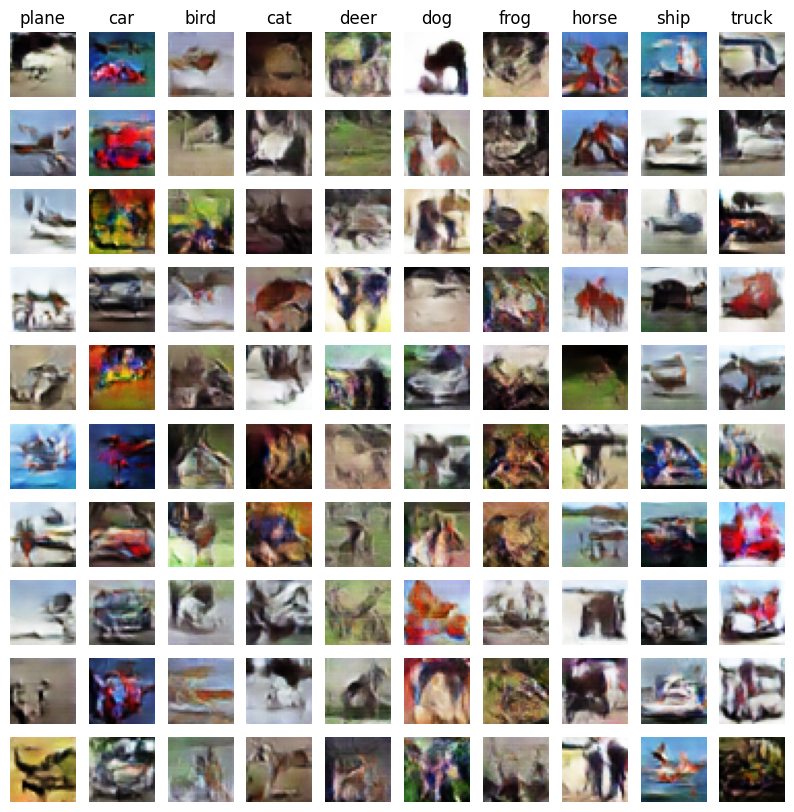

In [51]:
cond_model = load_model("models/cifar_cond_generator.100_epochs_100_latent_dims.model")
latent_points, labels = generate_conditional_latent_points(latent_dim, n_samples=100)
labels = np.asarray([x for _ in range(10) for x in range(10)])
X  = cond_model.predict([latent_points, labels], verbose=0)
X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)
show_cond_plot((X, 10)

**Conclusion**: Concatenating the class labels to the inputs to the generator (and discriminator) definitely improves the results. This makes a lot of sense - generating an image that is plausible only under the distribution of p(x|y) creates a more targetted, intentional result (e.g. the generated image is only compared to real pictures of horses), than when using a non-cGAN, where we check for images that are plausible under p(x), (e.g. evaluating if the generated image could be a realistic car/horse/deer/frog - a far more wider range, resulting in the odd, blurry morphs we saw earlier).

### Train the larger conditional model with 100 epochs:

In [52]:
latent_dim = 100
conditional_d_model = conditional_larger_discriminator()
conditional_g_model = conditional_larger_generator(latent_dim)
conditional_gan_model = conditional_gan(conditional_g_model, conditional_d_model)
conditional_dataset = load_real_conditional_samples()
n_epochs = 100
cond_filename = "models/cifar_larger_cond_generator." + str(n_epochs) + "_epochs_" + str(latent_dim) + "_latent_dims.model"
train(conditional_g_model, conditional_d_model, conditional_gan_model, conditional_dataset, latent_dim, n_epochs, cond_filename)

Epoch>1, discrim_real_loss=1.614, discrim_fake_loss=0.007 gen_loss=5.991
Epoch>2, discrim_real_loss=0.264, discrim_fake_loss=0.133 gen_loss=2.582
Epoch>3, discrim_real_loss=0.348, discrim_fake_loss=0.114 gen_loss=3.311
Epoch>4, discrim_real_loss=0.621, discrim_fake_loss=0.550 gen_loss=1.062
Epoch>5, discrim_real_loss=0.564, discrim_fake_loss=0.466 gen_loss=1.569
Epoch>6, discrim_real_loss=0.807, discrim_fake_loss=0.338 gen_loss=1.882
Epoch>7, discrim_real_loss=0.300, discrim_fake_loss=0.181 gen_loss=3.130
Epoch>8, discrim_real_loss=0.445, discrim_fake_loss=0.381 gen_loss=2.026
Epoch>9, discrim_real_loss=0.456, discrim_fake_loss=0.406 gen_loss=1.920
Epoch>10, discrim_real_loss=0.395, discrim_fake_loss=0.350 gen_loss=1.495
Epoch>11, discrim_real_loss=0.694, discrim_fake_loss=0.429 gen_loss=1.533
Epoch>12, discrim_real_loss=0.642, discrim_fake_loss=0.396 gen_loss=1.413
Epoch>13, discrim_real_loss=0.500, discrim_fake_loss=0.591 gen_loss=1.282
Epoch>14, discrim_real_loss=0.773, discrim_fake

INFO:tensorflow:Assets written to: cifar_larger_cond_generator.100_epochs_100_latent_dims.model/assets


INFO:tensorflow:Assets written to: cifar_larger_cond_generator.100_epochs_100_latent_dims.model/assets


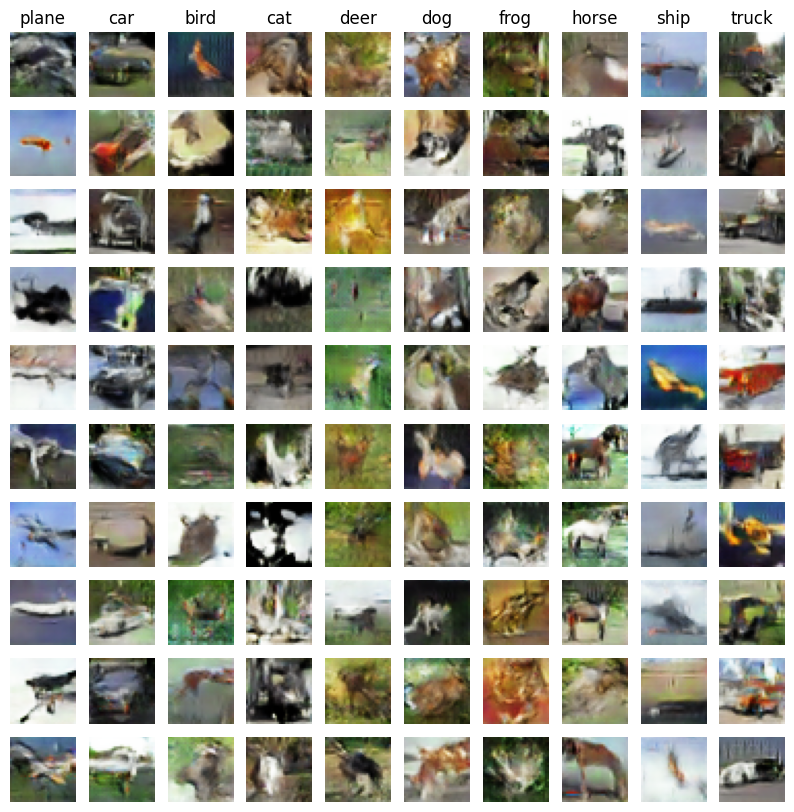

In [31]:
cond_model = load_model("models/cifar_larger_cond_generator.100_epochs_100_latent_dims.model")
latent_points, labels = generate_conditional_latent_points(latent_dim, n_samples=100)
labels = np.asarray([x for _ in range(10) for x in range(10)])
X  = cond_model.predict([latent_points, labels], verbose=0)
X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)
show_cond_plot(X, 10)

### Train the larger conditional model for 450 epochs:

2023-11-18 09:28:31.694577: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700


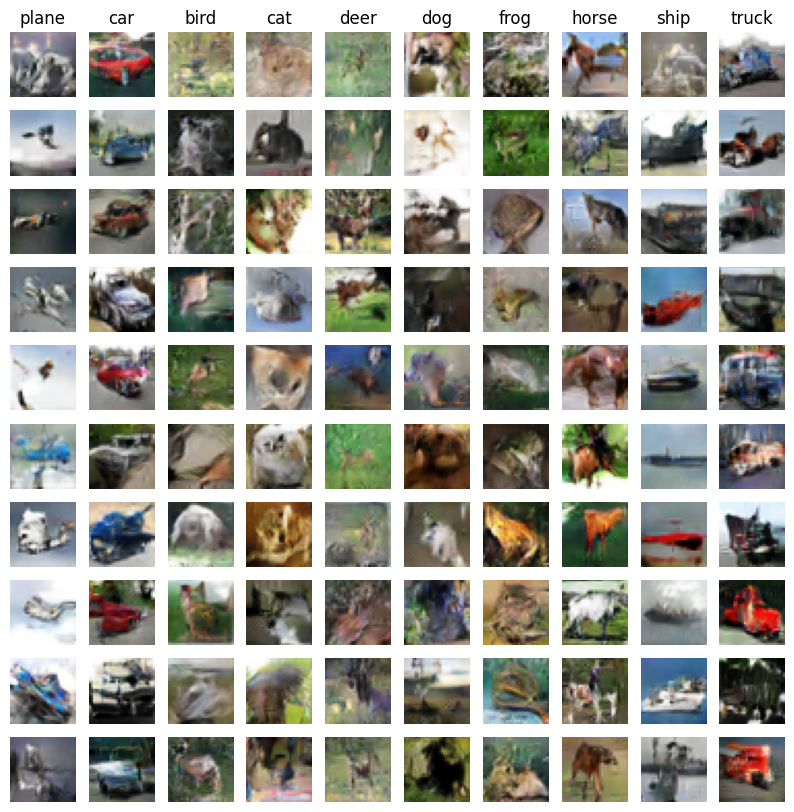

In [14]:
cond_model = load_model("models/cifar_larger_cond_generator.450_epochs_100_latent_dims.model")
latent_points, labels = generate_conditional_latent_points(100, n_samples=100)
labels = np.asarray([x for _ in range(10) for x in range(10)])
X  = cond_model.predict([latent_points, labels], verbose=0)
X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)
show_cond_plot(X, 10)

**Conclusion**: Training for high amounts of epochs really improves the results - for example, some of the cars look very realistic now. 

Of course, **how good the artificial images look is also dependent on a random element** - of which latent vector you happen to randomly sample - thus when running the "plot images" code multiple times, sometimes you happen to get good artificial images, sometimes bad, even when using the same model.

It is also interesting how **the losses don't really change much during training** - a consequence of the adversarial aspect of the model, where training each of the generator/discriminator models in turn tempers the loss of the other. Rather than looking at the losses, a better way to evaluate the progression of the model is therefore to plot some generated images every x epochs, and examine them by eye.